# Case Study 1

## Imorting Libraries

In [33]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Loading Dataset

Loading bike sharing dataset

In [34]:
df = pd.read_csv('/content/hours.csv')

##Exploring dataset

Analaysing the dataset, knowing more information about it.

Printing some values important to undetstand the dataset

In [35]:
print("df.head()\n")
print(df.head())
print("---------------------------------------------------------\n")
print("df.info()\n")
print(df.info())
print("---------------------------------------------------------\n")
print("df.describe()\n")
print(df.describe())
print("---------------------------------------------------------\n")
# df.tail()


df.head()

   instant    dteday  season  yr  mnth  hr  holiday   weekday  workingday  \
0        1  1/1/2011  Spring   0   1.0   0      0.0  Saturday           0   
1        2  1/1/2011  Spring   0   1.0   1      0.0  Saturday           0   
2        3  1/1/2011  Spring   0   1.0   2      0.0  Saturday           0   
3        4  1/1/2011  Spring   0   1.0   3      0.0  Saturday           0   
4        5  1/1/2011  Spring   0   1.0   4      0.0  Saturday           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered   cnt  
0         1.0  0.24  0.2879  0.81        0.0     3.0        13.0  16.0  
1         1.0  0.22  0.2727  0.80        0.0     8.0        32.0  40.0  
2         1.0  0.22  0.2727  0.80        0.0     5.0        27.0  32.0  
3         1.0  0.24  0.2879  0.75        0.0     3.0        10.0  13.0  
4         1.0  0.24  0.2879  0.75        0.0     0.0         1.0   1.0  
---------------------------------------------------------

df.info()

<class 'pandas.cor

info() will show us the summary of the dataframe including the data types of each column, the number of non-null values, and the memory usage

Describe() provides descriptive statistics for numerical columns in the DataFrame. It calculates various summary statistics such as count, mean, standard deviation, minimum, maximum, and quartile values for each numerical column.

Isnull().sum will show us the sumation of the null values in each feature.

In [36]:
df.isnull().sum()

,0
instant,0
dteday,0
season,0
yr,0
mnth,1
hr,0
holiday,12
weekday,1
workingday,0
weathersit,3


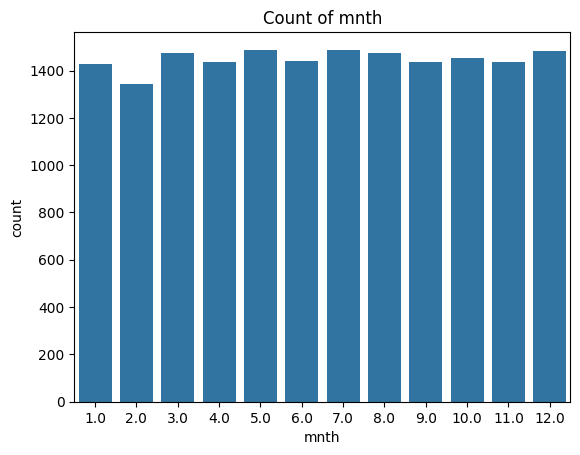

In [37]:
# Countplot for registered
sns.countplot(x='mnth', data=df)
plt.title('Count of mnth')
plt.show()


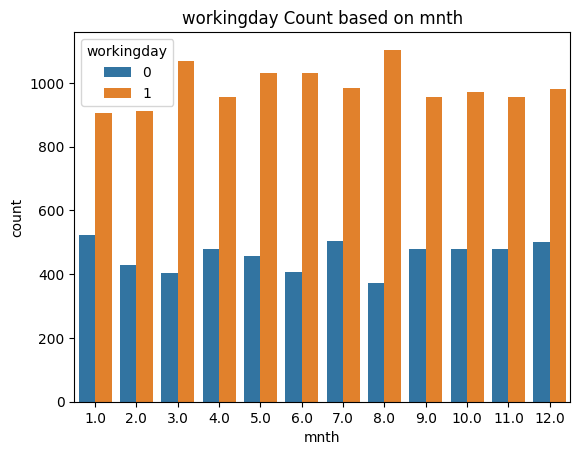

In [38]:
# Countplot for survival based on class
sns.countplot(x='mnth', hue='workingday', data=df)
plt.title('workingday Count based on mnth')
plt.show()

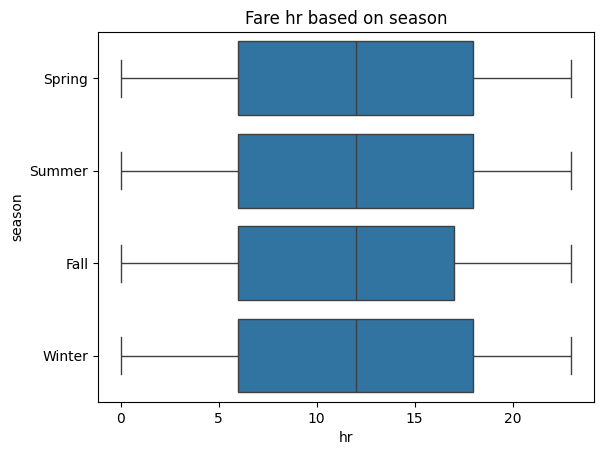

In [39]:
#
sns.boxplot(x='hr', y='season', data=df)
plt.title('Fare hr based on season')
plt.show()

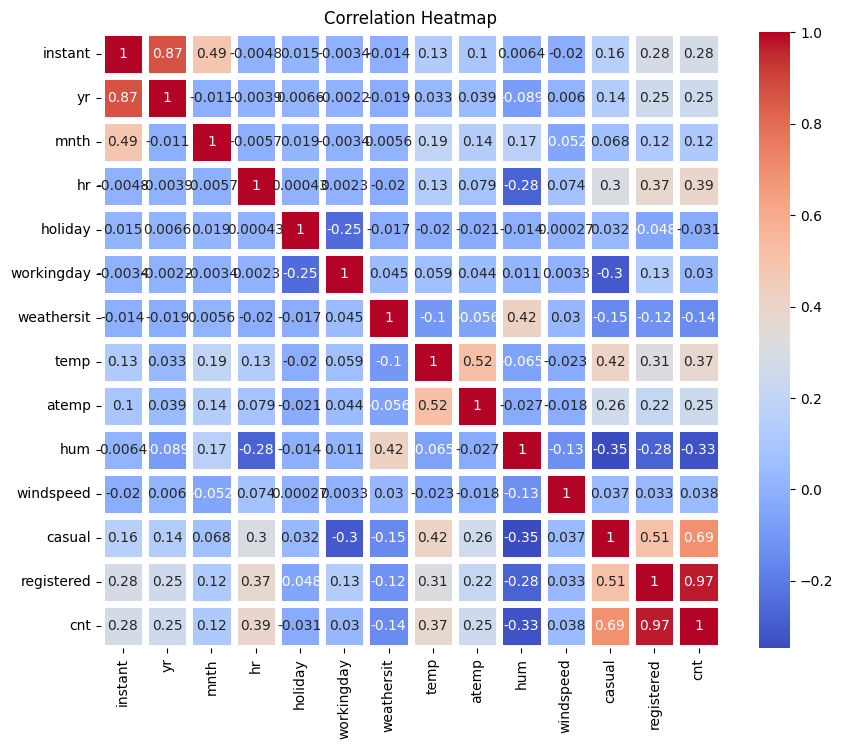

In [40]:
# Heatmap for correlation
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', linewidths=5.0)
plt.title('Correlation Heatmap')
plt.show()

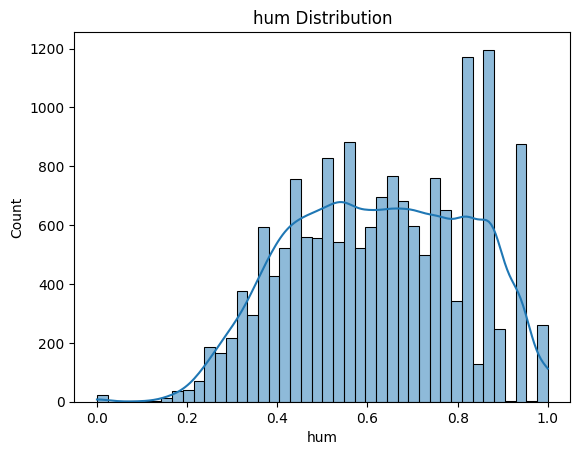

In [41]:
# hum distribution
sns.histplot(df['hum'].dropna(), kde=True)
plt.title('hum Distribution')
plt.show()

## Proccesing & Cleaning Data

## Missing Data Handling

Simple Imputation
For columns with few missing values, we'll fill in missing entries with the mode (most common value).

In [42]:
# Simple Imputation with the mode for columns with few missing values
mode_values = df[['mnth', 'holiday', 'weekday', 'weathersit', 'registered', 'cnt']].mode().iloc[0]
df[['mnth', 'holiday', 'weekday', 'weathersit', 'registered', 'cnt']] = df[['mnth', 'holiday', 'weekday', 'weathersit', 'registered', 'cnt']].fillna(mode_values)


Predictive Imputation
For casual, which has a moderate number of missing values, we'll use a simple model like k-Nearest Neighbors for imputation. Here, we'll use IterativeImputer from scikit-learn, which models each feature with missing values as a function of other features in a round-robin fashion

In [43]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Predictive imputation using IterativeImputer with RandomForestRegressor
imp = IterativeImputer(estimator=RandomForestRegressor(), initial_strategy='mean', max_iter=10, random_state=0)
df[['casual']] = imp.fit_transform(df[['casual']])


Advanced Techniques for Extensive Missing Data
For columns like temp, atemp, hum, and windspeed with substantial missing values, we will use linear interpolation, which is suitable for time series data.

In [44]:
# Advanced imputation using linear interpolation for time series data
df['temp'] = df['temp'].interpolate(method='linear')
df['atemp'] = df['atemp'].interpolate(method='linear')
df['hum'] = df['hum'].interpolate(method='linear')
df['windspeed'] = df['windspeed'].interpolate(method='linear')


Validation of Imputation
After imputation, it's good practice to check that no more missing values exist.

In [45]:
# Validate the imputation
print(df.isnull().sum())


instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


## Encoding into numerical data

Using Scikit-Learn for Label Encoding for "season" and "weekday"

In [46]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Apply label encoder on 'season' and 'weekday'
df['season'] = label_encoder.fit_transform(df['season'])
df['weekday'] = label_encoder.fit_transform(df['weekday'])


Encoding the dteday column
The dteday column represents dates and should be transformed into a more useful numerical format:
This conversion separates the date into distinct year, month, and day components, which are more useful for regression analysis and other modeling techniques than a string format.

In [47]:
# Convert 'dteday' to datetime type
df['dteday'] = pd.to_datetime(df['dteday'])

# Extract year, month, and day as separate columns
df['year'] = df['dteday'].dt.year
df['month'] = df['dteday'].dt.month
df['day'] = df['dteday'].dt.day

# Optionally, drop 'dteday' if no longer needed
df.drop('dteday', axis=1, inplace=True)


Finalizing the DataFrame

In [48]:
print(df.head())
print(df.info())

   instant  season  yr  mnth  hr  holiday  weekday  workingday  weathersit  \
0        1       1   0   1.0   0      0.0        2           0         1.0   
1        2       1   0   1.0   1      0.0        2           0         1.0   
2        3       1   0   1.0   2      0.0        2           0         1.0   
3        4       1   0   1.0   3      0.0        2           0         1.0   
4        5       1   0   1.0   4      0.0        2           0         1.0   

   temp   atemp   hum  windspeed  casual  registered   cnt  year  month  day  
0  0.24  0.2879  0.81        0.0     3.0        13.0  16.0  2011      1    1  
1  0.22  0.2727  0.80        0.0     8.0        32.0  40.0  2011      1    1  
2  0.22  0.2727  0.80        0.0     5.0        27.0  32.0  2011      1    1  
3  0.24  0.2879  0.75        0.0     3.0        10.0  13.0  2011      1    1  
4  0.24  0.2879  0.75        0.0     0.0         1.0   1.0  2011      1    1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 e

## indentifying outliers

Using Z-score for Outlier Detection

In [49]:
from scipy.stats import zscore

# Calculate Z-scores of the data
df_numeric = df.select_dtypes(include=[np.number])  # selecting numeric columns
df_numeric['z_score_temp'] = zscore(df_numeric['temp'])

# Filter entries that have a temperature z-score greater than 3 or less than -3
outliers_temp = df_numeric[(df_numeric['z_score_temp'] > 3) | (df_numeric['z_score_temp'] < -3)]
print("Temperature Outliers based on Z-score:")
print(outliers_temp)


Temperature Outliers based on Z-score:
       instant  season  yr  mnth  hr  holiday  weekday  workingday  \
15531    15532       3   1  10.0   8      0.0        3           0   
16534    16535       3   1  11.0  16      0.0        1           1   
16535    16536       3   1  11.0  17      0.0        1           1   
16536    16537       3   1  11.0  18      0.0        1           1   
16537    16538       3   1  11.0  19      0.0        1           1   
16538    16539       3   1  11.0  20      0.0        1           1   
16539    16540       3   1  11.0  21      0.0        1           1   
16540    16541       3   1  11.0  22      0.0        1           1   

       weathersit  temp   atemp   hum  windspeed  casual  registered    cnt  \
15531         1.0   1.6  0.4394  0.77    0.30084    28.0       104.0  132.0   
16534         1.0   2.0  0.4394  0.30    0.00000    49.0       297.0  346.0   
16535         1.0   3.0  0.4242  0.32    0.00000    13.0       540.0  553.0   
16536         

Using IQR to Detect Outliers in Humidity

In [50]:
# Calculate Q1, Q3, and IQR
Q1 = df['hum'].quantile(0.25)
Q3 = df['hum'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as those values outside the IQR * 1.5 criterion
outliers_hum = df[(df['hum'] < (Q1 - 1.5 * IQR)) | (df['hum'] > (Q3 + 1.5 * IQR))]
print("Humidity Outliers based on IQR:")
print(outliers_hum)


Humidity Outliers based on IQR:
      instant  season  yr  mnth  hr  holiday  weekday  workingday  weathersit  \
1551     1552       1   0   3.0   0      0.0        4           1         3.0   
1552     1553       1   0   3.0   1      0.0        4           1         3.0   
1553     1554       1   0   3.0   2      0.0        4           1         3.0   
1554     1555       1   0   3.0   5      0.0        4           1         3.0   
1555     1556       1   0   3.0   6      0.0        4           1         3.0   
1556     1557       1   0   3.0   7      0.0        4           1         3.0   
1557     1558       1   0   3.0   8      0.0        4           1         3.0   
1558     1559       1   0   3.0   9      0.0        4           1         3.0   
1559     1560       1   0   3.0  10      0.0        4           1         3.0   
1560     1561       1   0   3.0  11      0.0        4           1         3.0   
1561     1562       1   0   3.0  12      0.0        4           1         3.0

Visualizing Outliers with Boxplots

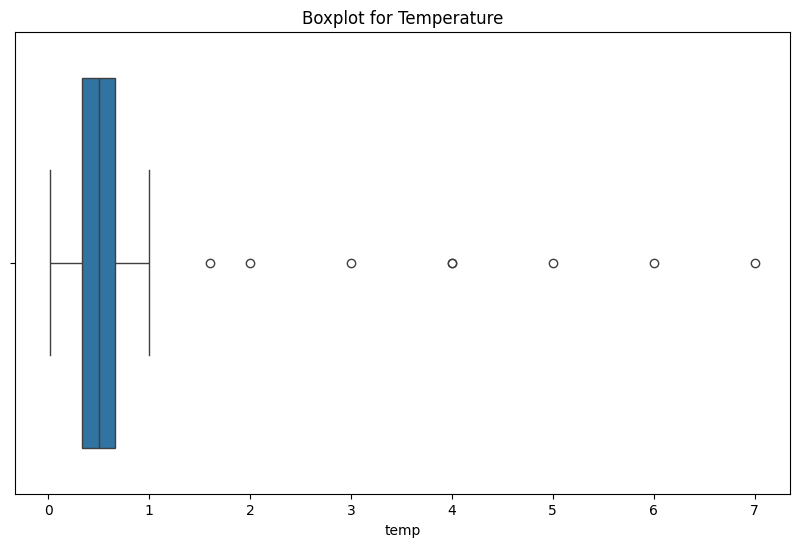

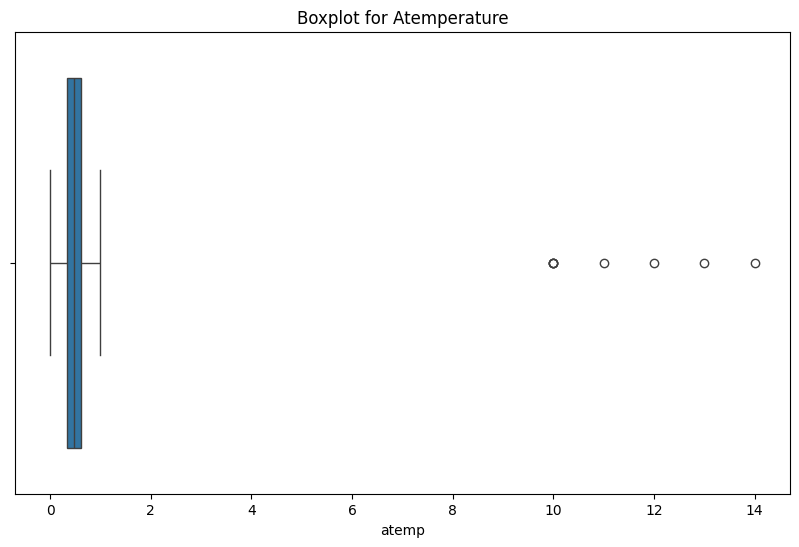

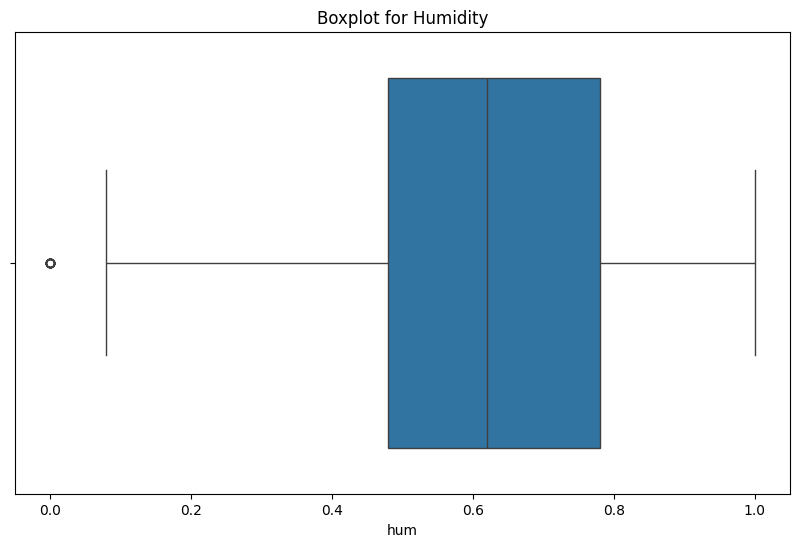

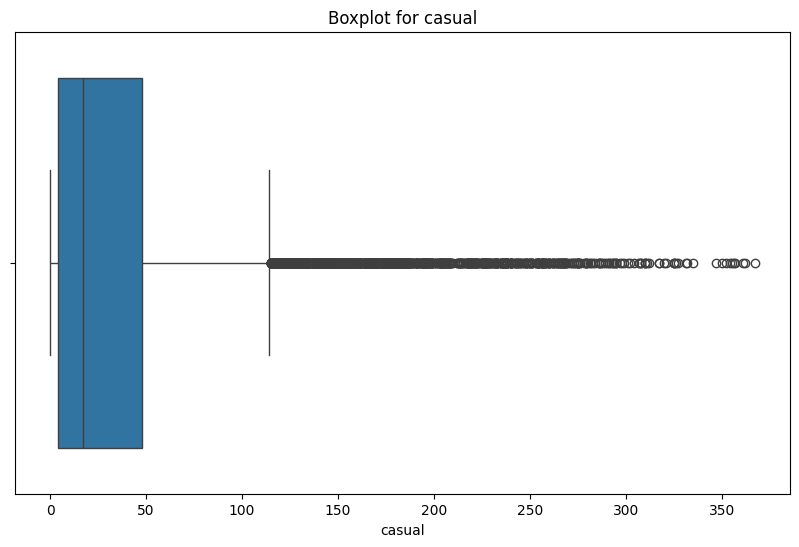

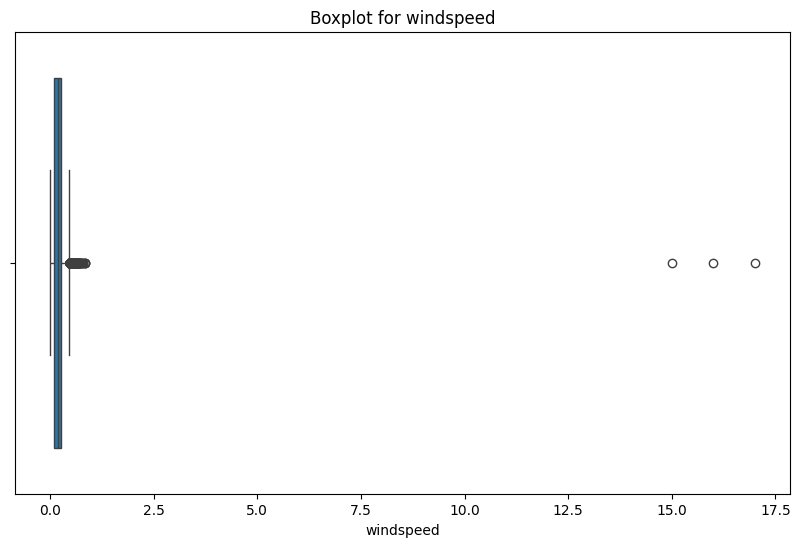

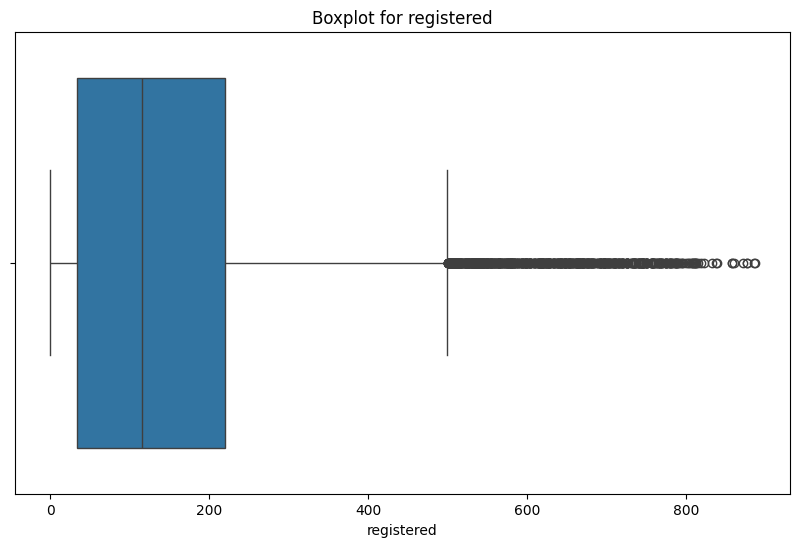

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot for temperature
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['temp'])
plt.title('Boxplot for Temperature')
plt.show()

# Boxplot for Atemperature
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['atemp'])
plt.title('Boxplot for Atemperature')
plt.show()

# Boxplot for humidity
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['hum'])
plt.title('Boxplot for Humidity')
plt.show()

# Boxplot for casual
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['casual'])
plt.title('Boxplot for casual')
plt.show()

# Boxplot for windspeed
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['windspeed'])
plt.title('Boxplot for windspeed')
plt.show()

# Boxplot for registered
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['registered'])
plt.title('Boxplot for registered')
plt.show()





IQR Method: The function find_iqr_outliers calculates the interquartile range (IQR) for a given column and determines outliers as those values that fall outside of 1.5 times the IQR from the Q1 and Q3 quartiles.

Outlier Collection: We collect all outliers from each numeric column and keep track of their indices.

Consolidated View: All indices of outliers are used to create a new DataFrame from the original dataset, which includes only the rows that contain outlier values in any of their columns.

In [52]:
import pandas as pd
import numpy as np

# Function to find outliers based on the IQR method
def find_iqr_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return column[(column < lower_bound) | (column > upper_bound)]

# Selecting numeric columns for outlier detection
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Dictionary to hold outliers for each column
outliers_dict = {}

# Applying the outlier detection on each column
for col in numeric_cols:
    outliers = find_iqr_outliers(df[col])
    if not outliers.empty:
        outliers_dict[col] = outliers

# Consolidating all outliers' indices to fetch the rows from the original DataFrame
all_outlier_indices = set()
for outlier_series in outliers_dict.values():
    all_outlier_indices.update(outlier_series.index.tolist())

# Creating a DataFrame of all outliers for review
all_outliers_df = df.loc[sorted(all_outlier_indices)]

print("All Outliers Across DataFrame:")
print(all_outliers_df)


All Outliers Across DataFrame:
       instant  season  yr  mnth  hr  holiday  weekday  workingday  \
175        176       1   0   1.0  14      0.0        2           0   
178        179       1   0   1.0  17      0.0        2           0   
194        195       1   0   1.0   9      0.0        3           0   
196        197       1   0   1.0  11      0.0        3           0   
265        266       1   0   1.0  12      0.0        6           1   
...        ...     ...  ..   ...  ..      ...      ...         ...   
17327    17328       1   1  12.0  20      0.0        2           0   
17328    17329       1   1  12.0  21      0.0        2           0   
17341    17342       1   1  12.0  10      0.0        3           0   
17343    17344       1   1  12.0  12      0.0        3           0   
17344    17345       1   1  12.0  13      0.0        3           0   

       weathersit  temp   atemp   hum  windspeed  casual  registered    cnt  \
175           1.0  0.20  0.1667  0.32     0.4925 

Explanation of output above

Index and Columns:

Each row represents a data entry in your dataset where at least one column has a value that deviates significantly from the norm (based on the IQR or Z-score method used).
Columns include instant, season, yr, mnth, hr, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed, casual, registered, cnt.

Displayed Rows:

The rows (175, 178, 194, etc.) are indices from the original DataFrame that correspond to outliers.
The table shows 2583 rows identified with outlier values, indicating these are the rows with unusual or extreme values in at least one of their columns.

Typical Values in Outlier Data:

Temporal Data: Columns like yr, mnth, hr, weekday, and workingday help to contextualize when these outliers occur, which could be useful to identify any temporal patterns related to outliers.
Environmental Conditions: weathersit, temp, atemp, hum, and windspeed may show extremities in weather conditions contributing to outlier values. For example, extreme weather conditions might correlate with unusual bike rental patterns.
Usage Data: casual, registered, and cnt show the bike rental counts that are unusually high or low. High outliers could represent very popular hours/days or specific events affecting rentals, while low outliers might indicate hours with poor weather or operational issues.

## Scaling

Standard Scaling is used

StandardScaler removes the mean and scales each feature/variable to unit variance. This is less affected by outliers and often is the preferred method for algorithms that assume data is normally distributed.

In [53]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

# I have decided to scale only these values since other values don't really need scaling
# List of columns to scale, assuming you want to scale all numeric data
columns_to_scale = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered']

# Apply Standard Scaling
df[columns_to_scale] = standard_scaler.fit_transform(df[columns_to_scale])

# Print the first few rows to check the result of scaling
print("\nStandard Scaled Data:")
print(df.head())
DataSet = df.copy()



Standard Scaled Data:
   instant  season  yr  mnth  hr  holiday  weekday  workingday  weathersit  \
0        1       1   0   1.0   0      0.0        2           0         1.0   
1        2       1   0   1.0   1      0.0        2           0         1.0   
2        3       1   0   1.0   2      0.0        2           0         1.0   
3        4       1   0   1.0   3      0.0        2           0         1.0   
4        5       1   0   1.0   4      0.0        2           0         1.0   

       temp     atemp       hum  windspeed    casual  registered   cnt  year  \
0 -1.227782 -0.665588  0.952034  -0.801944 -0.663317   -0.929741  16.0  2011   
1 -1.322727 -0.718060  0.900048  -0.801944 -0.561713   -0.804231  40.0  2011   
2 -1.322727 -0.718060  0.900048  -0.801944 -0.622675   -0.837260  32.0  2011   
3 -1.227782 -0.665588  0.640119  -0.801944 -0.663317   -0.949559  13.0  2011   
4 -1.227782 -0.665588  0.640119  -0.801944 -0.724279   -1.009011   1.0  2011   

   month  day  
0      1   

## Feature selection

Using Random Forest for Feature Importance

In [54]:
from sklearn.ensemble import RandomForestRegressor

df_standard_scaled = df.copy()

# Assuming 'df_standard_scaled' is the DataFrame you want to use
X = df_standard_scaled.drop('cnt', axis=1)  # Features
y = df_standard_scaled['cnt']               # Target variable

# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame to view the features and their importance scores
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)


       Feature  Importance
14  registered    0.947185
13      casual    0.051966
0      instant    0.000158
11         hum    0.000125
4           hr    0.000102
7   workingday    0.000094
12   windspeed    0.000064
8   weathersit    0.000063
17         day    0.000047
6      weekday    0.000045
10       atemp    0.000043
9         temp    0.000040
16       month    0.000024
1       season    0.000021
3         mnth    0.000014
2           yr    0.000005
15        year    0.000002
5      holiday    0.000002


while  the goal is to predict total bike rentals without prior knowledge of user type breakdowns (casual vs. registered), I am rebuilding the model without the casual and registered features. This would provide insights into what other factors influence rental counts and how much they matter.

In [55]:
# Drop 'casual' and 'registered' features
X_revised = df_standard_scaled.drop(['cnt', 'casual', 'registered'], axis=1)
y_revised = df_standard_scaled['cnt']

# Fit the model on revised data
rf_revised = RandomForestRegressor(n_estimators=100, random_state=42)
rf_revised.fit(X_revised, y_revised)

# Get revised feature importances
revised_importances = rf_revised.feature_importances_
revised_feature_names = X_revised.columns
revised_feature_importances = pd.DataFrame({'Feature': revised_feature_names, 'Importance': revised_importances})
revised_feature_importances = revised_feature_importances.sort_values(by='Importance', ascending=False)
print(revised_feature_importances)


       Feature  Importance
4           hr    0.583847
0      instant    0.165432
7   workingday    0.084162
9         temp    0.068057
10       atemp    0.024966
11         hum    0.022167
8   weathersit    0.015734
6      weekday    0.011088
15         day    0.010654
12   windspeed    0.006640
14       month    0.002021
3         mnth    0.002017
1       season    0.001609
5      holiday    0.001474
2           yr    0.000075
13        year    0.000057


explaining the above:

**Revised Feature Importance Analysis**

Hour of Day (hr): The most significant feature with an importance of approximately 58.4%. This indicates that the time of day is crucial for predicting bike rentals, which aligns with daily patterns of human activity (e.g., commuting times in the morning and evening).

Instant (instant): Surprisingly, this feature, which likely represents a unique identifier for each record, holds substantial importance at 16.5%. This might suggest some chronological trends in the data or could be an artifact of how data was collected or indexed.

Working Day (workingday): With an importance of 8.4%, this feature signifies whether a day is a regular working day or not, influencing rental patterns due to commuting behavior.

Temperature (temp): Contributing 6.8% importance, this reflects the intuitive understanding that weather conditions affect outdoor activities like biking.

Feels Like Temperature (atemp) and Humidity (hum): These also play roles but to a lesser extent, emphasizing the effect of perceived environmental conditions on rental decisions.

Weather Situation (weathersit) and Windspeed (windspeed): Lesser but notable effects, indicating adverse weather can deter bike usage.



**Interpretation:**

Time Dependency: The high importance of hr and instant underscores the time-sensitive nature of bike rentals. These features help capture patterns across different times of the day and potentially across the dataset's timeline.

Weather and Environmental Factors: temp, atemp, hum, and weathersit confirm the expected influence of weather on biking habits. Even though their individual importances are not as high as hr, they collectively account for a significant portion of the predictive power.

Work-Related Usage: The significance of workingday aligns with usage patterns where bikes are likely used more on workdays, possibly for commuting to work or other regular activities.

## Machine Learning

Before Applying PCA

In [56]:
# Assuming df_standard_scaled is your DataFrame after standard scaling
features = df_standard_scaled.drop(['cnt', 'casual', 'registered'], axis=1)
target = df_standard_scaled['cnt']

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train a Random Forest model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 1687.650786306099
R-squared: 0.9467103835046389


Applying PCA

In [57]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'df_standard_scaled' is pre-processed and scaled
X = df_standard_scaled.drop(['cnt', 'casual', 'registered'], axis=1)
y = df_standard_scaled['cnt']

# Initialize PCA: Choosing to keep 95% of the variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate the model
predictions = rf.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Number of components: {pca.n_components_}")


Mean Squared Error: 7248.354312945915
R-squared: 0.7711244383651028
Number of components: 1


 Experiment with adjusting the number of principal components. Instead of setting a variance ratio, try using a fixed number of components and evaluate how the model performance changes.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'df_standard_scaled' is pre-processed and scaled
X = df_standard_scaled.drop(['cnt', 'casual', 'registered'], axis=1)
y = df_standard_scaled['cnt']

# Initialize PCA: adjusting the number of principal components. Instead of setting a variance ratio (14)
pca = PCA(n_components=14)
X_pca = pca.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate the model
predictions = rf.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Number of components: {pca.n_components_}")


# Case Study 2

**For this case study, we took the already processed and cleaned data afrom case study 1, and worked with it**

In [59]:
DataSet.head()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,year,month,day
0,1,1,0,1.0,0,0.0,2,0,1.0,-1.227782,-0.665588,0.952034,-0.801944,-0.663317,-0.929741,16.0,2011,1,1
1,2,1,0,1.0,1,0.0,2,0,1.0,-1.322727,-0.718060,0.900048,-0.801944,-0.561713,-0.804231,40.0,2011,1,1
2,3,1,0,1.0,2,0.0,2,0,1.0,-1.322727,-0.718060,0.900048,-0.801944,-0.622675,-0.837260,32.0,2011,1,1
3,4,1,0,1.0,3,0.0,2,0,1.0,-1.227782,-0.665588,0.640119,-0.801944,-0.663317,-0.949559,13.0,2011,1,1
4,5,1,0,1.0,4,0.0,2,0,1.0,-1.227782,-0.665588,0.640119,-0.801944,-0.724279,-1.009011,1.0,2011,1,1


In [61]:
DataSet.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,year,month,day
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,1.737900e+04,1.737900e+04,1.737900e+04,1.737900e+04,1.737900e+04,1.737900e+04,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,1.482019,0.502561,6.538006,11.546752,0.028770,2.992405,0.682721,1.425111,3.139978e-16,-5.887459e-17,1.537281e-16,7.195784e-17,9.485351e-17,-7.686405e-17,189.392773,2011.502561,6.537775,15.683411
std,5017.0295,1.119902,0.500008,3.438539,6.914405,0.167165,1.997884,0.465431,0.639337,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,181.404168,0.500008,3.438776,8.789373
min,1.0000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-2.272171e+00,-1.659440e+00,-3.258818e+00,-8.019436e-01,-7.242786e-01,-1.015617e+00,1.000000,2011.000000,1.000000,1.000000
25%,4345.5000,0.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,-7.530600e-01,-5.088643e-01,-7.634983e-01,-3.682573e-01,-6.429958e-01,-7.910191e-01,40.000000,2011.000000,4.000000,8.000000
50%,8690.0000,1.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,6.495712e-03,1.412472e-02,-3.569670e-02,3.177343e-03,-3.788268e-01,-2.559469e-01,142.000000,2012.000000,7.000000,16.000000
75%,13034.5000,2.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,7.660514e-01,4.849875e-01,7.960765e-01,2.509388e-01,2.511148e-01,4.376652e-01,281.000000,2012.000000,10.000000,23.000000
max,17379.0000,3.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,3.086345e+01,4.666958e+01,1.939765e+00,6.974989e+01,6.733417e+00,4.837148e+00,977.000000,2012.000000,12.000000,31.000000


**Categorizing Demand**

**We need a function to categorize the count, so we defined the categories based on quartiles.**

In [62]:
def categorize_demand(cnt):
    if cnt <= DataSet['cnt'].quantile(0.25):
        return 'low'
    elif cnt <= DataSet['cnt'].quantile(0.50):
        return 'medium'
    elif cnt <= DataSet['cnt'].quantile(0.75):
        return 'high'
    else:
        return 'extreme'

# Apply the categorization function
DataSet['demand_category'] = DataSet['cnt'].apply(categorize_demand)


**To see the results**

In [72]:
DataSet.head()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,year,month,day,demand_category
0,1,1,0,1.0,0,0.0,2,0,1.0,-1.227782,-0.665588,0.952034,-0.801944,-0.663317,-0.929741,16.0,2011,1,1,low
1,2,1,0,1.0,1,0.0,2,0,1.0,-1.322727,-0.718060,0.900048,-0.801944,-0.561713,-0.804231,40.0,2011,1,1,low
2,3,1,0,1.0,2,0.0,2,0,1.0,-1.322727,-0.718060,0.900048,-0.801944,-0.622675,-0.837260,32.0,2011,1,1,low
3,4,1,0,1.0,3,0.0,2,0,1.0,-1.227782,-0.665588,0.640119,-0.801944,-0.663317,-0.949559,13.0,2011,1,1,low
4,5,1,0,1.0,4,0.0,2,0,1.0,-1.227782,-0.665588,0.640119,-0.801944,-0.724279,-1.009011,1.0,2011,1,1,low


**For Feature Selection and Data Splitting, we'll use the same set of features we considered earlier in case study 1, excluding casual and registered if they are still present to avoid data leakage.**

In [65]:
features = DataSet.drop(['cnt', 'casual', 'registered', 'demand_category'], axis=1)
target = DataSet['demand_category']

# Splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

**Model Training and Evaluation**

**We set up each model invdividually, then we will later call it**

In [66]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Multilayer Perceptron
mlp = MLPClassifier(random_state=42)


**Train and Evaluate Models**

Accuracy of RandomForestClassifier: 0.80897583429229
              precision    recall  f1-score   support

     extreme       0.86      0.86      0.86       840
        high       0.71      0.73      0.72       858
         low       0.90      0.92      0.91       853
      medium       0.77      0.74      0.76       925

    accuracy                           0.81      3476
   macro avg       0.81      0.81      0.81      3476
weighted avg       0.81      0.81      0.81      3476



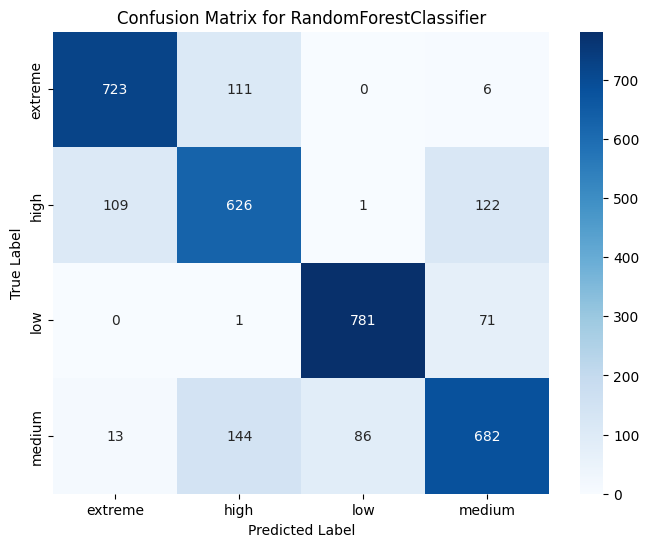

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:35:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy of XGBClassifier: 0.8578826237054085
              precision    recall  f1-score   support

     extreme       0.88      0.89      0.89       840
        high       0.80      0.80      0.80       858
         low       0.93      0.91      0.92       853
      medium       0.83      0.83      0.83       925

    accuracy                           0.86      3476
   macro avg       0.86      0.86      0.86      3476
weighted avg       0.86      0.86      0.86      3476



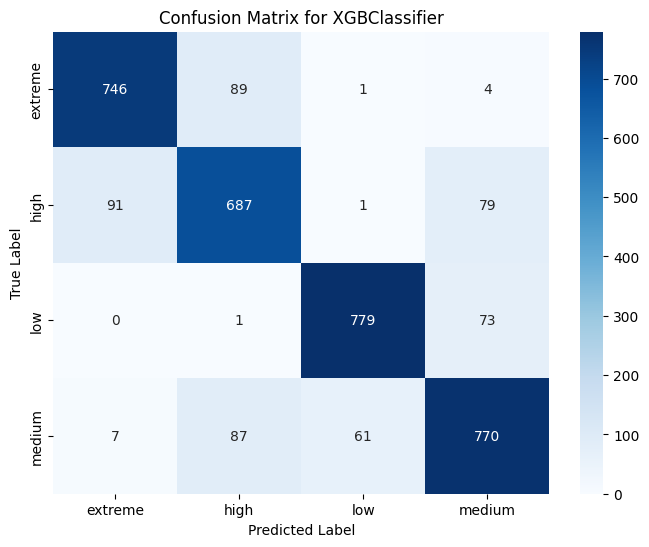

Accuracy of MLPClassifier: 0.32163406214039125
              precision    recall  f1-score   support

     extreme       0.00      0.00      0.00       840
        high       0.29      0.91      0.44       858
         low       0.64      0.16      0.25       853
      medium       0.36      0.22      0.27       925

    accuracy                           0.32      3476
   macro avg       0.32      0.32      0.24      3476
weighted avg       0.32      0.32      0.24      3476



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


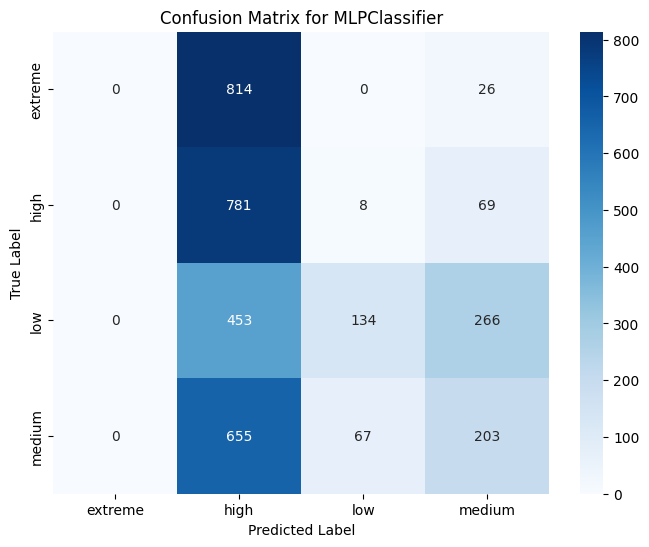

In [71]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


# Initialize label encoder
label_encoder = LabelEncoder()

# Encode target labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#---------------------------------------------------------------------------

# Update the train_evaluate function to use encoded labels for XGBoost
def train_evaluate(model, X_train, y_train, X_test, y_test, is_xgb=False):
    if is_xgb:  # Check if the model is XGBoost
        # Fit and predict using encoded labels
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
    else:
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

    # Use inverse transform to get original labels for evaluation if it's XGBoost
    if is_xgb:
        predictions = label_encoder.inverse_transform(predictions)
        actual_y_test = label_encoder.inverse_transform(y_test)
    else:
        actual_y_test = y_test

    # Print accuracy and classification report
    print(f"Accuracy of {model.__class__.__name__}: {accuracy_score(actual_y_test, predictions)}")
    print(classification_report(actual_y_test, predictions))

    # Compute and print the confusion matrix
    cm = confusion_matrix(actual_y_test, predictions, labels=label_encoder.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


#---------------------------------------------------------------------------

# Train and evaluate Random Forest
train_evaluate(rf, X_train, y_train, X_test,y_test)

# Train and evaluate XGBoost
train_evaluate(xgb, X_train, y_train_encoded, X_test, y_test_encoded, is_xgb=True)

# Train and evaluate MLP
train_evaluate(mlp, X_train, y_train, X_test, y_test)



**Plotting performancce differences**

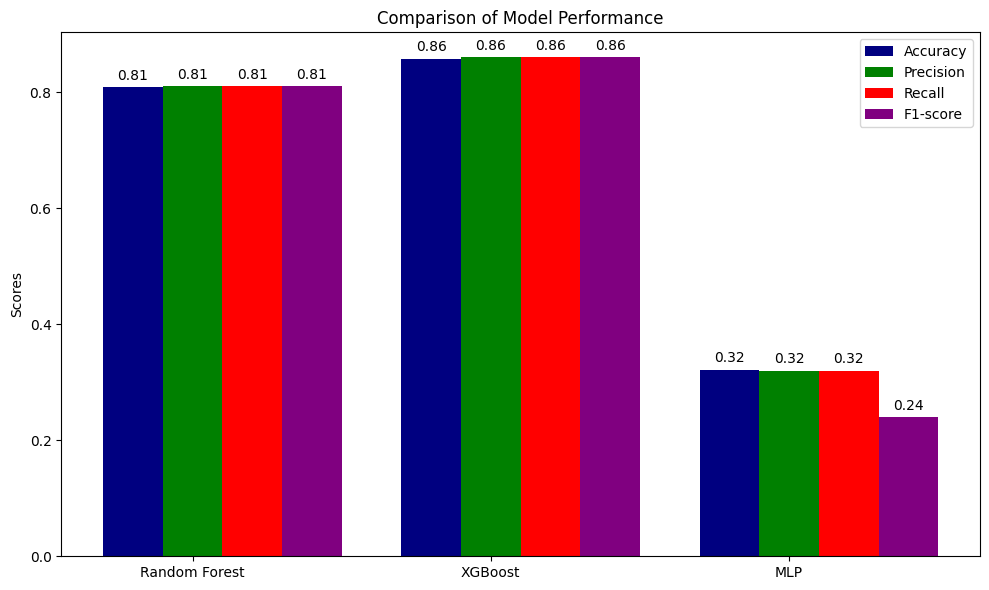

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Define the models and their metrics
models = ['Random Forest', 'XGBoost', 'MLP']
accuracy = [0.80898, 0.85788, 0.32163]  # Actual accuracies from your results
precision = [0.81, 0.86, 0.32]  # Estimated from your provided average precision
recall = [0.81, 0.86, 0.32]  # Estimated from your provided average recall
f1 = [0.81, 0.86, 0.24]  # Estimated from your provided average F1-scores

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting accuracy
rects1 = ax.bar(x - width, accuracy, width, label='Accuracy', color='navy')

# Plotting precision
rects2 = ax.bar(x, precision, width, label='Precision', color='green')

# Plotting recall
rects3 = ax.bar(x + width, recall, width, label='Recall', color='red')

# Plotting F1-score
rects4 = ax.bar(x + 2*width, f1, width, label='F1-score', color='purple')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Function to attach labels to bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Adding labels to bars
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.show()
